# Proyek Akhir Dicoding: Klasifikasi Gambar (Gunting-kertas-batu)

## Data diri
Nama : Abdul Azis Sukmawan\
Username : amawan\
Email : sukmawanabdul@gmail.com\
Status : Mahasiswa\
Tempat tinggal : Kabupaten Tangerang


In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [ ]:
!wget -q -P /content/ https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip

### Unzip dataset

In [ ]:
!unzip -q /content/rockpaperscissors.zip

### Defining directory data
Ukuran validation set harus 40% dari total dataset (data training memiliki 1314 sampel, dan data validasi sebanyak 874 sampel).

In [ ]:
base_dir = '/content/rockpaperscissors/rps-cv-images'
papers_dir = os.path.join(base_dir, 'paper')
rocks_dir = os.path.join(base_dir, 'rock')
scissors_dir = os.path.join(base_dir, 'scissors')

print(f"There are {len(os.listdir(papers_dir))} images of paper.\n")
print(f"There are {len(os.listdir(rocks_dir))} images of rock.\n")
print(f"There are {len(os.listdir(scissors_dir))} images of scissors.\n")

There are 712 images of paper.

There are 726 images of rock.

There are 750 images of scissors.



### Sample images

Sample paper image:


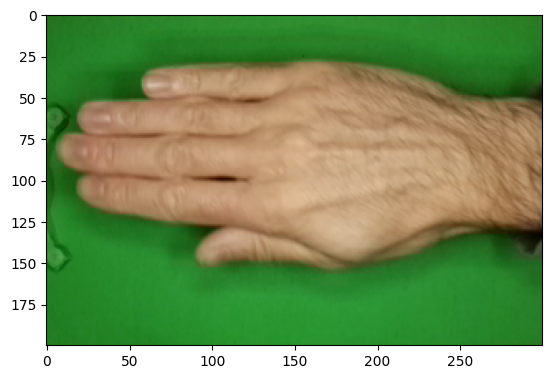


Sample rock image:


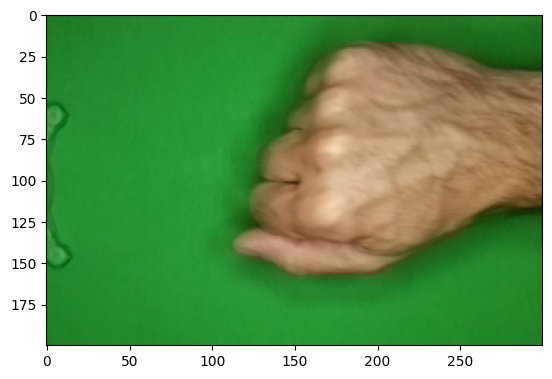


Sample scissor image:


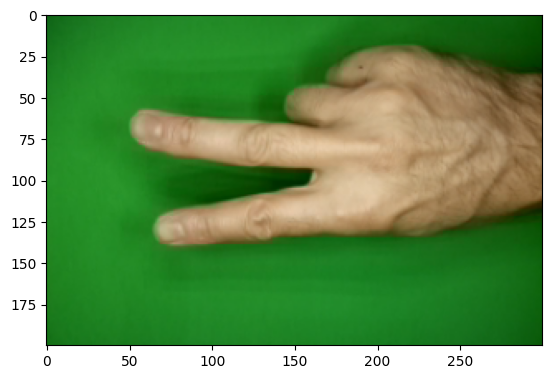

In [ ]:
print("Sample paper image:")
plt.imshow(load_img(f"{os.path.join(papers_dir, os.listdir(papers_dir)[0])}"))
plt.show()

print("\nSample rock image:")
plt.imshow(load_img(f"{os.path.join(rocks_dir, os.listdir(rocks_dir)[0])}"))
plt.show()

print("\nSample scissor image:")
plt.imshow(load_img(f"{os.path.join(scissors_dir, os.listdir(scissors_dir)[0])}"))
plt.show()

### Look dimension shape image

In [ ]:
sample_image_paper  = load_img(f"{os.path.join(papers_dir, os.listdir(papers_dir)[0])}")
sample_image_rock  = load_img(f"{os.path.join(rocks_dir, os.listdir(rocks_dir)[0])}")
sample_image_scissor  = load_img(f"{os.path.join(scissors_dir, os.listdir(scissors_dir)[0])}")

# Convert the image into its numpy array representation
sample_array_paper = img_to_array(sample_image_paper)
sample_array_rock = img_to_array(sample_image_rock)
sample_array_scissor = img_to_array(sample_image_scissor)

print(f"Sample image paper has shape: {sample_array_paper.shape}")
print(f"Sample image rock shape: {sample_array_rock.shape}")
print(f"Sample image scissor shape: {sample_array_scissor.shape}")

Sample image paper has shape: (200, 300, 3)
Sample image rock shape: (200, 300, 3)
Sample image scissor shape: (200, 300, 3)


### Split data and Training and Validation Generators

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest',
                                   validation_split=0.4)

train_generator = train_datagen.flow_from_directory(base_dir,
                                                    target_size=(150,150),
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    subset='training')

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.4)

validation_generator =  validation_datagen.flow_from_directory(base_dir,
                                                               target_size=(150,150),
                                                               batch_size=32,
                                                               class_mode='categorical',
                                                               subset='validation')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


### Setup modelTransfer learning - Create the pre-trained model

disini saya menggunakan convolution layers transfer learning [InceptionV3](https://arxiv.org/abs/1512.00567), disini mengenerate model yang sudah di latih dengan jutaan gambar dan ribuan kelas dari website https://image-net.org/

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-11-09 09:03:04--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 74.125.134.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   111MB/s    in 0.8s    

2023-11-09 09:03:05 (111 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Buat sebuah instance inception model dari local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights = None)

pre_trained_model.load_weights(local_weights_file)

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 21,768,352 trainable parameters in this model.


### Setup callback for later

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98 and logs.get('val_accuracy')>0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


### Setup Final model(my model)

In [ ]:
def create_final_model(pre_trained_model):

  model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3,activation='softmax')
  ])

  model.layers[0].trainable = False

  # Compile model
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

  return model

In [ ]:
model = create_final_model(pre_trained_model)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 31,306,531 total parameters in this model.
There are 9,503,747 trainable parameters in this model.


### Model evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
def evaluate(model):

  validation_generator = train_datagen.flow_from_directory(
          base_dir,
          target_size=(150,150),
          batch_size=32,
          class_mode='categorical',
          shuffle = False,
          subset='validation')

  batch_size = 32
  num_of_train_samples = 1314
  num_of_test_samples = 874

  Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('\nConfusion Matrix\n')
  print(confusion_matrix(validation_generator.classes, y_pred))


  print('\n\nClassification Report\n')
  target_names = ['Rock', 'Paper', 'Scissors']
  print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

### Training model and visualize hostory loss, accuracy

Epoch 1/100
11/11 [==============================] - 30s 1s/step - loss: 6.7371 - accuracy: 0.5510 - val_loss: 0.3764 - val_accuracy: 0.9314
Epoch 2/100
11/11 [==============================] - 12s 1s/step - loss: 1.1977 - accuracy: 0.8425 - val_loss: 0.2110 - val_accuracy: 0.9600
Epoch 3/100
11/11 [==============================] - 12s 1s/step - loss: 0.4183 - accuracy: 0.9216 - val_loss: 0.1174 - val_accuracy: 0.9600
Epoch 4/100
11/11 [==============================] - 12s 1s/step - loss: 0.2786 - accuracy: 0.9330 - val_loss: 0.0667 - val_accuracy: 0.9783
Epoch 5/100
11/11 [==============================] - 12s 1s/step - loss: 0.1779 - accuracy: 0.9384 - val_loss: 0.0695 - val_accuracy: 0.9737
Epoch 6/100
11/11 [==============================] - 12s 1s/step - loss: 0.1681 - accuracy: 0.9498 - val_loss: 0.0613 - val_accuracy: 0.9794
Epoch 7/100
11/11 [==============================] - 12s 1s/step - loss: 0.1563 - accuracy: 0.9581 - val_loss: 0.0687 - val_accuracy: 0.9725
Epoch 8/100
1

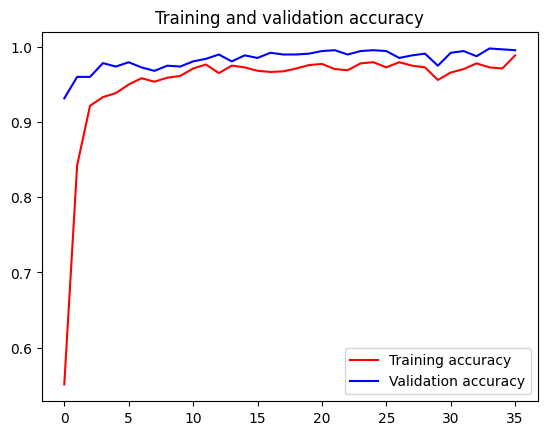

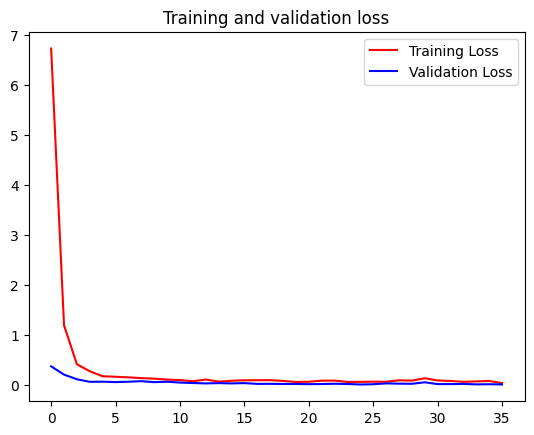

In [ ]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 1,
                    callbacks=callbacks)

# Plot chart untuk accuracy dan loss training and validation
print('\n')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate mode

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    batch_size=159,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle = False
)

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model.predict_generator(validation_generator, steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['Rock', 'Paper', 'Scissors']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 2188 images belonging to 3 classes.


<ipython-input-18-705e64821e50>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, steps = nb_samples)


Confusion Matrix
[[711   0   1]
 [  5 721   0]
 [  2   0 748]]
Classification Report
              precision    recall  f1-score   support

        Rock       0.99      1.00      0.99       712
       Paper       1.00      0.99      1.00       726
    Scissors       1.00      1.00      1.00       750

    accuracy                           1.00      2188
   macro avg       1.00      1.00      1.00      2188
weighted avg       1.00      1.00      1.00      2188



### Testing data

In [ ]:

def predict_image(image_upload, model = model):
  im = image_upload

  import numpy as np
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Paper', 'Rock', 'Scissors']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'Paper'
  elif predict_label == 1:
      predict_product = 'Rock'
  else:
      predict_product = 'Scissor'

  return predict_product, df

Saving photo_2023-11-09_16-24-09.jpg to photo_2023-11-09_16-24-09.jpg
1/1 [==============================] - 0s 160ms/step




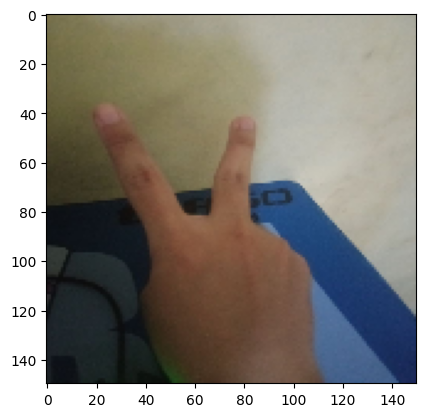


The image is detected as Scissor


    Product  Probability
0     Paper     0.107115
1      Rock     0.002693
2  Scissors     0.890193




In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  img = load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')